<a href="https://colab.research.google.com/github/austinbrehm/machine-learning/blob/main/predict_transaction_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Transaction Count for Ethereum Block
Use linear regression to predict the transaction count for an Ethereum block based on gas used.

Steps:
1. Get data
1. Split data for training and testing
1. Build model
1. Compile model
1. Train model
1. Test model
1. Plot prediction



In [ ]:
# Import libraries.
import requests
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import userdata

In [ ]:
# Get Ethereum block data using the Etherscan API.
api_key = userdata.get("etherscan_keys")
last_block_data = requests.get(
    "https://api.etherscan.io/v2/api?chainid=1&module=proxy"
    f"&action=eth_blockNumber&apikey={api_key}"
)
last_block_number = int(last_block_data.json()["result"], 16)

blocks = []
for i in range(100):
    block_hash = hex(random.randint(last_block_number - 10_000, last_block_number))
    blocks.append(block_hash)

transactions = []
gas_used = []
for block in blocks:
    block_data = requests.get(
      "https://api.etherscan.io/api?module=proxy&action=eth_getBlockByNumber"
      f"&tag={block}&boolean=true&apikey={api_key}"
    )
    transaction_count = len(block_data.json()["result"]["transactions"])
    transactions.append(transaction_count)

    gas = int(block_data.json()["result"]["gasUsed"], 16)
    gas_used.append(gas)

transactions = np.array(transactions)
gas_used = np.array(gas_used)

<ipython-input-86-acee6096fb1a>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")


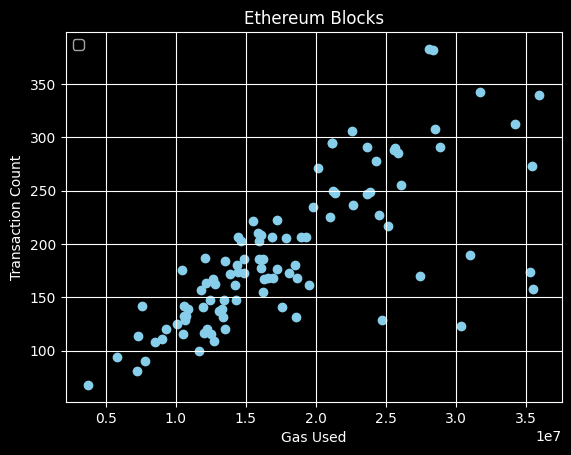

In [ ]:
# Plot data.
plt.style.use("dark_background")
plt.scatter(gas_used, transactions, marker="o", c="skyblue")
plt.title("Ethereum Blocks")
plt.xlabel("Gas Used")
plt.ylabel("Transaction Count")
plt.grid()
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Split the data for training and testing.
split_index = int(len(transactions) * 0.7)
train_txs, test_txs = np.array_split(transactions, [split_index])
train_gas, test_gas = np.array_split(gas_used, [split_index])

In [ ]:
# Build linear regression model.
gas_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
gas_normalizer.adapt(train_gas)

model = tf.keras.Sequential([
    gas_normalizer,
    tf.keras.layers.Dense(units=1)
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [ ]:
# Run the model.
model.predict(train_gas[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


array([[ 0.15007149],
       [-0.08245882],
       [-0.0150968 ],
       [-0.07983784],
       [ 0.11561316],
       [-0.2225922 ],
       [ 0.01021102],
       [ 0.05640871],
       [ 0.10459882],
       [ 0.22618452]], dtype=float32)

In [ ]:
# Compile the model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [ ]:
# Train the model.
history = model.fit(
    train_gas,
    train_txs,
    epochs=1000,
    verbose=0,
    validation_split = 0.3
)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,33.623341,36.702538,995
996,33.577190,36.630806,996
997,33.532787,36.556171,997
998,33.481773,36.481510,998
999,33.442287,36.402515,999


In [ ]:
# Test the model.
test_results = {}
test_results["model"] = model.evaluate(test_gas, test_txs, verbose=0)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


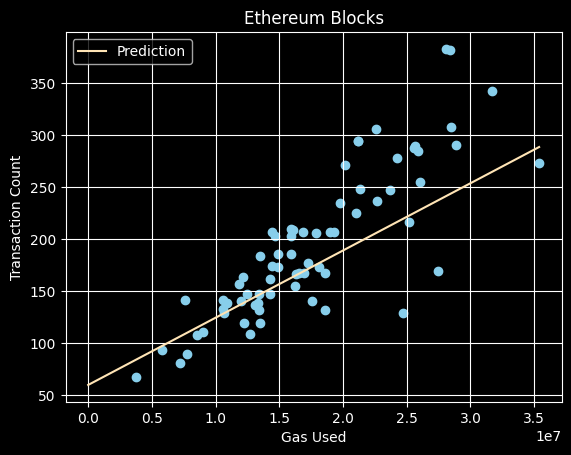

In [ ]:
# Plot the prediction.
x = tf.linspace(0, np.max(train_gas), 1000)
y = model.predict(x)

plt.style.use("dark_background")
plt.scatter(train_gas, train_txs, marker="o", c="skyblue")
plt.plot(x, y, "moccasin", label="Prediction")
plt.title("Ethereum Blocks")
plt.xlabel("Gas Used")
plt.ylabel("Transaction Count")
plt.grid()
plt.legend(loc="upper left")
plt.show()